In [1]:
from fenics import *
from dolfin import *
#from mshr import *
import matplotlib.pyplot as plt


comm = MPI.comm_world
rank = MPI.rank(comm)

data = HDF5File(comm, f"data_test_count_49_w_0.2236_time_2000.h5", 'r')

mesh = Mesh()
data.read(mesh, "mesh", False)

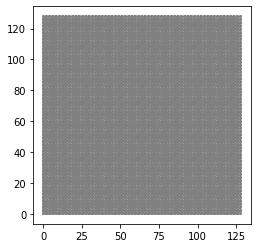

In [2]:
plot(mesh)

In [3]:
nx = 60
ny = 60
LX = 128 
LY = 128

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    def inside(self, x, on_boundary):
        return bool((near(x[0], 0) or near(x[1], 0)) and
                (not ((near(x[0], 0) and near(x[1], LY)) or
                        (near(x[0], LX) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], LX) and near(x[1], LY):
            y[0] = x[0] - LX
            y[1] = x[1] - LY
        elif near(x[0], LX):
            y[0] = x[0] - LX
            y[1] = x[1]
        else:   # near(x[1], 127)
            y[0] = x[0]
            y[1] = x[1] - LY

In [4]:
V = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim = 2)
Q = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
MFS = FunctionSpace(mesh, MixedElement([Q, V]), constrained_domain = PeriodicBoundary())

VFS = FunctionSpace(mesh, V, constrained_domain = PeriodicBoundary())
FS  = FunctionSpace(mesh, Q, constrained_domain = PeriodicBoundary())

u_new = Function(MFS) 
w = Function(FS)
(rho_new, tau_new) = split(u_new)

In [20]:
import numpy as np

x = np.linspace(0, LX, nx)
y = np.linspace(0, LY, ny)
xx, yy = np.meshgrid(x, y, sparse = False, indexing = 'ij')



In [81]:
total_time = 2000
step = 2


time = np.arange(0, total_time, step)
Inertia = []

def calculate_inertia(rho_array):
    
    test_rho = np.zeros([nx, ny])
    thres = 1.07
    mask = rho_array > thres
    test_rho = np.where(mask, rho_array, 0)

    cmx, cmy, M = 0, 0, 0
    for i in range(nx):
        for j in range(ny):
            cmx = cmx + i*test_rho[i, j]
            cmy = cmy + j*test_rho[i, j]
            M = M + test_rho[i, j]
    cmx = cmx/M
    cmy = cmy/M
    Ixx, Iyy, Ixy = 0, 0, 0

    for x in range(nx):
        for y in range(ny):
            Ixx = Ixx + test_rho[x, y]*(y - cmy)**2
            Iyy = Iyy + test_rho[x, y]*(x - cmx)**2
            Ixy = Ixy - test_rho[x, y]*(x - cmx)*(y - cmy)
            
    I = np.asarray([[Ixx, Ixy], [Ixy, Iyy]])
    eigenvalues, eigenvectors = np.linalg.eig(I)
    
    inertia = eigenvalues[1]/eigenvalues[0]
    
    return inertia

    
for t in range(0, total_time, step):
    
    if(t % 100 == 0):
        print(f"step : {t}", flush = True)
    
    data.read(u_new, f"u_new/Vector/vector_{t}")

    rho, tau = u_new.split()


    rho_f = np.vectorize(rho)
    rho_array = rho_f(xx,yy)
    
    Inertia.append(calculate_inertia(rho_array))


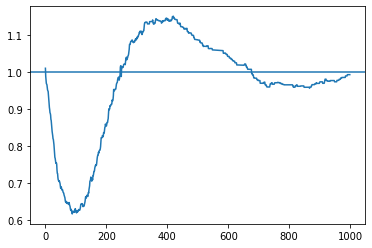

In [83]:
plt.plot(Inertia)
plt.axhline(y = 1)